In [1]:
import torch
from sklearn.model_selection import train_test_split
img = torch.load('bone-features.pt')
img = img.to(torch.double).numpy()
lab = torch.load('bone-labels.pt').numpy()

In [2]:
import main_gaussian 
import frank_wolfe
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from sklearn import preprocessing
from importlib import reload
from collections import defaultdict
reload(frank_wolfe)
reload(main_gaussian)

from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

import torch
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
def evaluate_subset(train_subset, train_x, train_y, test_x, test_y, use_ridge=False):
    if isinstance(train_x, torch.Tensor):
        train_x = train_x.numpy()
        train_y = train_y.numpy()
        test_x = test_x.numpy()
        test_y = test_y.numpy()
    if use_ridge:
        reg = Ridge(fit_intercept=False)
    else:
        reg = LinearRegression(fit_intercept=False)
    reg.fit(train_x[train_subset], train_y[train_subset])
    pred = reg.predict(test_x)
    error = mean_squared_error(test_y, pred)
    return error

from main_gaussian import get_data, design_selection
import frank_wolfe

from importlib import reload
reload(frank_wolfe)
reload(main_gaussian)


[KeOps] Warning : There were warnings or errors compiling formula :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:5:10: fatal error: nvrtc.h: No such file or directory
    5 | #include <nvrtc.h>
      |          ^~~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc bin

<module 'main_gaussian' from '/u/luchar/data-markets/main_gaussian.py'>

In [131]:
# num_seller = 10000
num_seller = 15000
num_buyer = 10
dim = 1000

noise_level=1
# noise_level=0.5
# noise_level=0.1

def h(c, a=1, b=0): return c**a + b

# bone_data = True
bone_data = False

if bone_data:
    noise_level=0.1
    
    x_sell, x_buy, y_sell, y_buy = train_test_split(img[:num_seller], lab[:num_seller], test_size=num_buyer, random_state=0)
    x_sell = np.concatenate([
        x_buy[:10],
        x_buy[:10],
        x_buy[:10],
        x_sell,
    ])
    y_sell = np.concatenate([
        y_buy[:10],
        y_buy[:10],
        y_buy[:10],
        y_sell,
    ])
    
    costs = np.ones(x_sell.shape[0])
    costs[0:10] = np.linspace(1, 2, 10)
    costs[10:20] = np.linspace(2, 1, 10)
    costs[20:30] = np.linspace(1, 2, 10)
    # costs[20:30] = 3
    costs[30:] = np.random.choice(np.linspace(1, 2, 10), size=costs[30:].shape[0])
    
    x_sell = x_sell + (noise_level * costs[:, None] * np.random.randn(*x_sell.shape))
    # y_sell = y_sell + noise_level * costs * np.random.randn(x_sell.shape[0])
else:
    x_sell = np.random.normal(size=(num_seller, dim))
    x_sell /= np.linalg.norm(x_sell, axis=1, keepdims=True)  # normalize data
    
    beta_true = np.random.exponential(scale=1, size=dim)
    beta_true *= np.sign(np.random.random(size=dim))
    
    x_buy = np.random.normal(size=[num_buyer, dim])
    x_buy /= np.linalg.norm(x_buy, axis=1, keepdims=True) 
    y_buy = x_buy @ beta_true
    
    x_sell = np.concatenate([
        x_buy,
        x_buy,
        x_buy,
        x_sell,
    ])
    
    costs = np.ones(x_sell.shape[0])
    costs[0:10] = np.linspace(1, 10, 10)
    costs[10:20] = np.linspace(10, 1, 10)
    costs[20:30] = np.linspace(1, 10, 10)
    costs[30:] = np.random.choice(np.linspace(1, 10, 10), size=costs[30:].shape[0])
    x_sell = np.einsum('i,ij->ij', h(costs, a=0.5), x_sell)
    y_sell = x_sell @ beta_true + noise_level * np.random.randn(x_sell.shape[0])

print('subset difference', np.mean(np.abs(y_buy - y_sell[:num_buyer])))
print('seller difference', np.mean(np.abs(y_buy - y_sell[-num_buyer:])))

sel = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print('0-9\t', 
      frank_wolfe.MSE(
    x_buy, y_buy, 
    frank_wolfe.least_norm_linear_regression(
        x_sell[sel], y_sell[sel])
).round(1)
     )

sel = [0, 1, 2, 3, 4, 15, 16, 17, 18, 19]
print('0-5, 15-19\t', 
      frank_wolfe.MSE(
    x_buy, y_buy, 
    frank_wolfe.least_norm_linear_regression(
        x_sell[sel], y_sell[sel])
).round(1)
     )

sel = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
print('20-29\t', 
      frank_wolfe.MSE(
    x_buy, y_buy, 
    frank_wolfe.least_norm_linear_regression(
        x_sell[sel], y_sell[sel])
).round(1)
     )

# sel = range(100, 110)
sel = range(200, 210)
print('random\t', 
      frank_wolfe.MSE(
    x_buy, y_buy, 
    frank_wolfe.least_norm_linear_regression(
        x_sell[sel], y_sell[sel])
).round(1)
     )

subset difference 1.3318861108943252
seller difference 2.0428021304804167
0-9	 0.1
0-5, 15-19	 0.2
20-29	 0.2
random	 2.4


In [140]:
# num_iters = 1000
# num_iters = 50
# num_iters = 2*num_buyer
num_iters = num_buyer
# num_iters = 1
# num_iters = 2
# num_iters = 3

# multi_step = True
multi_step = False
 
n_sell = x_sell.shape[0]

# w = np.ones(n_sell) / n_sell
w = np.zeros(n_sell)

# inv_cov = np.eye(x_sell.shape[1]) 
# inv_cov = np.linalg.pinv(np.dot(x_sell.T @ np.diag(w), x_sell))
inv_cov = np.linalg.pinv(np.dot(x_sell.T, x_sell)) * n_sell

updates = []
losses = []
errors = []
for t in range(1, num_iters + 1):
    
    # alpha = (init_alpha + 1) / (t + 1)
    alpha = 2 / (3 + t)
    # alpha = 0.1
    
    neg_grad = frank_wolfe.compute_neg_gradient(x_sell, x_buy, inv_cov)
    update = np.argmax((1 / costs) * neg_grad)
    # update = np.argmax(neg_grad)
    updates.append(update)
    
    loss = frank_wolfe.compute_exp_design_loss(x_buy, inv_cov)
    losses.append(loss)
    error = frank_wolfe.MSE(
        x_buy, y_buy, 
        frank_wolfe.least_norm_linear_regression(
            x_sell[w.argsort()[-num_buyer:]], y_sell[w.argsort()[-num_buyer:]])
    )
    errors.append(error)
    
    print(
        t,
        '    ',
        round(loss, 4),
        '    ',
        round(error, 4),
        '    ',
        update,
        '    ',
        alpha, 

    )
    
    # print(update)

    if multi_step:
        coords = np.argsort((1 / costs) * neg_grad)[::-1]
        print(coords[:10])
        # for i in range(1, num_buyer + 1):
        # for i in range(0, num_buyer):
        for i in range(0, num_buyer):
            alpha_i = alpha / (3 + i)
            # w *= (1 - alpha_i)
            w[coords[i]] += alpha_i
            # inv_cov /= 1 - alpha_i 
    else:
        # w /= (1 - alpha)
        # w *= (1 - alpha)
        
        w[update] += alpha
        # inv_cov = np.linalg.pinv(x_sell.T @ np.diag(w) @ x_sell)
        
        # inv_cov *= 1 - alpha 
        # inv_cov /= 1 - alpha 
        
    inv_cov = frank_wolfe.sherman_morrison_update_inverse( 
        inv_cov,
        alpha * x_sell[update, :],
        x_sell[update, :],
    )

w /= w.sum()
# neg_grad

1      162.8992      1.5838      11      0.5
2      145.7473      2.0386      10      0.4
3      128.7002      1.6432      12      0.3333333333333333
4      112.081      1.6019      13      0.2857142857142857
5      95.5193      1.6112      4      0.25
6      79.0959      1.332      7      0.2222222222222222
7      63.021      0.7534      6      0.2
8      47.1629      0.7013      5      0.18181818181818182
9      31.3929      0.1508      18      0.16666666666666666
10      16.063      0.1594      9      0.15384615384615385


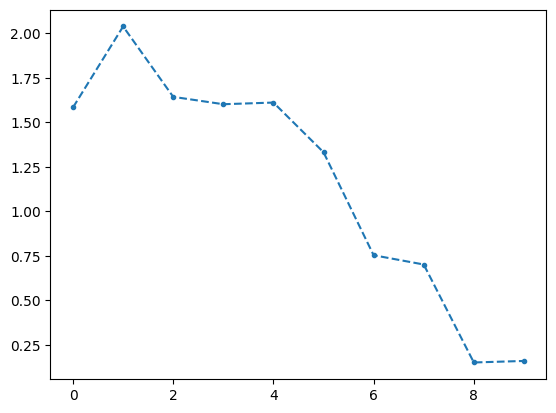

In [141]:
plt.plot(errors, ls='--', marker='.')
# plt.xlim(0, 20)
# plt.yscale('log')

Text(0, 0.5, 'Error')

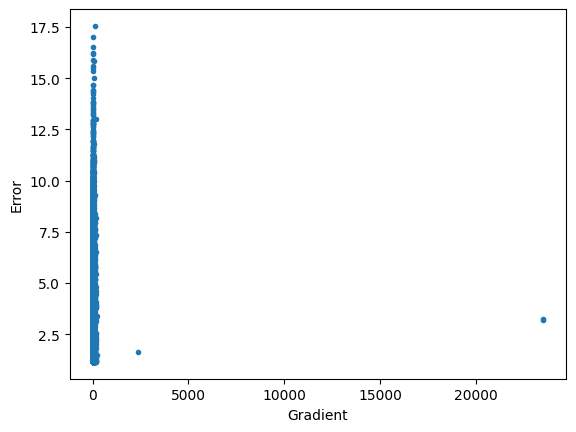

In [142]:
plt.scatter(neg_grad,
[np.mean(np.abs(y_buy - y)) for y in y_sell],
          marker='.')
# plt.ylim(0, 3)
plt.xlabel('Gradient')
plt.ylabel('Error')

In [143]:
des_mse = []
for _ in range(10):
    des_sel_samp = np.random.choice(np.arange(len(x_sell)), p=w / w.sum(), size=num_buyer, replace=False)
    des_mse.append(frank_wolfe.MSE(
        x_buy, y_buy, 
        frank_wolfe.least_norm_linear_regression(x_sell[des_sel_samp], y_sell[des_sel_samp])
    ))
print('Ours', np.mean(des_mse).round(3))
des_sel_sort = w.argsort()[::-1][:num_buyer]
print(sorted(des_sel_samp))
print()

print('Ours (non-sampled)', frank_wolfe.MSE(x_buy, y_buy, frank_wolfe.least_norm_linear_regression(x_sell[des_sel_sort], y_sell[des_sel_sort])).round(3))
print(sorted(des_sel_sort))
print()

inv_cov = np.linalg.pinv(np.dot(x_sell.T, x_sell))
grad_sel = ((1/costs) * frank_wolfe.compute_neg_gradient(x_sell, x_buy, inv_cov)).argsort()[::-1][:num_buyer]
print('grad', 
      frank_wolfe.MSE(
    x_buy, y_buy, 
    frank_wolfe.least_norm_linear_regression(x_sell[grad_sel], y_sell[grad_sel])
).round(3))
print(sorted(grad_sel))
print()


ran_mse = []
for _ in range(10):
    ran_sel = np.random.choice(np.arange(len(x_sell)), size=num_buyer, replace=False)
    ran_mse.append(frank_wolfe.MSE(
        x_buy, y_buy, 
        frank_wolfe.least_norm_linear_regression(x_sell[ran_sel], y_sell[ran_sel])
    ))
print('Random', np.mean(ran_mse).round(2))
print(sorted(ran_sel))
print()

Ours 0.099
[4, 5, 6, 7, 9, 10, 11, 12, 13, 18]

Ours (non-sampled) 0.099
[4, 5, 6, 7, 9, 10, 11, 12, 13, 18]

grad 1.603
[0, 1, 2, 10, 11, 12, 13, 20, 21, 22]

Random 2.21
[115, 2124, 3311, 3994, 7197, 7569, 7605, 11460, 11797, 13522]



In [144]:
# w[:10].sum(), w[:20].sum(), w[:30].sum(), w[:40].sum(), w[:5000].sum()

Text(0, 0.5, 'Weight')

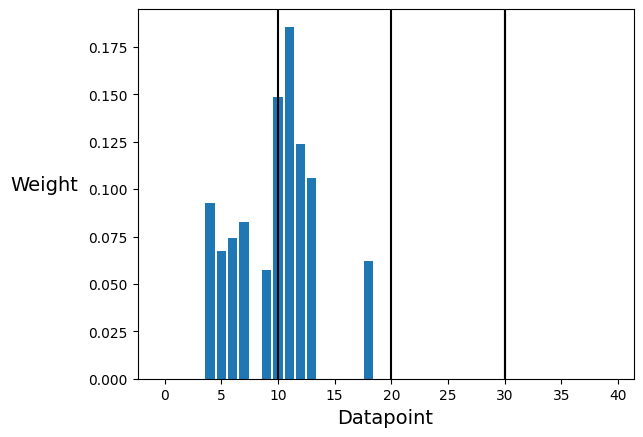

In [145]:
plt.axvline(10, c='k')
plt.axvline(20, c='k')
plt.axvline(30, c='k')
plt.axvline(30, c='k')
plt.bar(np.arange(0, 40), w[:40])
plt.xlabel('Datapoint', fontsize=14)
plt.ylabel('Weight', fontsize=14, rotation=0, labelpad=32)
# plt.text(0, 0.17, r'cost = np.linspace(1, 10, 10)')
# plt.text(12, 0.17, r'cost = np.linspace(10, 1, 10)')

In [146]:
dummy = np.ones((4, x_sell.shape[1])), np.ones((4))
oob_values = main_gaussian.get_baseline_values(
    x_sell, y_sell, *dummy, *dummy, 
    baseline_kwargs={"DataOob": {"num_models": 100}},
)

----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/it]


	TIME: 170


In [147]:
oob_values[0]['DataOob'].argsort()[::-1][:10]

array([ 3973, 13262,   561,  8133,  2924,  4993, 11332,  8444,  7022,
        5345])

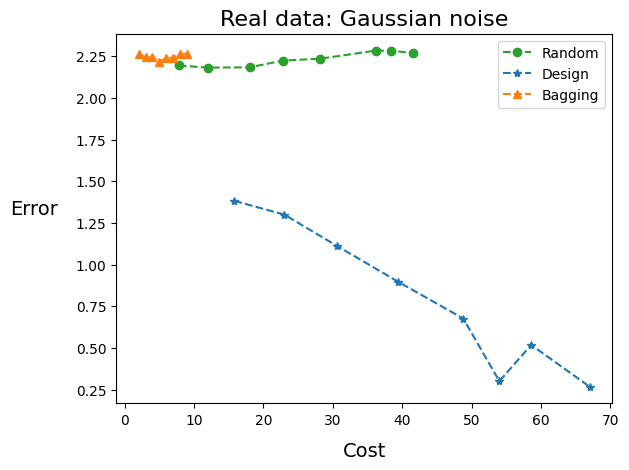

In [148]:
# TODO  change x-axis to budget instead of cost
trials = 5

rang = list(range(2, num_buyer, 1)) 
rand_err  = []
rand_cost = []
for _ in range(trials):
    perm = np.random.permutation(np.arange(x_sell.shape[0]))
    rand_err.append([
        frank_wolfe.MSE(
            x_buy, y_buy, 
            frank_wolfe.least_norm_linear_regression(x_sell[perm][:k], y_sell[perm][:k])
        )
        for k in rang
    ])
    rand_cost.append([costs[perm][:k].sum() for k in rang])
    
design_err = []
design_cost = []
for _ in range(trials):
    derr = []
    dcos = []
    for k in rang:
        sel = np.random.choice(np.arange(len(x_sell)), p=w / w.sum(), size=k, replace=False)
        dcos.append(costs[sel].sum())
        derr.append(frank_wolfe.MSE(
            x_buy, y_buy, 
            frank_wolfe.least_norm_linear_regression(x_sell[sel], y_sell[sel]),
        ))
    design_err.append(derr)
    design_cost.append(dcos)

    
plt.plot(
    np.mean(rand_cost, 0),
    np.mean(rand_err, 0),
    label='Random', ls='--', c='C2', marker='o'
)
plt.plot(
    np.mean(design_cost, 0),
    np.mean(design_err, 0),
    label='Design', ls='--', c='C0', marker='*',
)
                
# plt.plot(
#     [costs[w.argsort()[-k:]].sum() for k in rang], [
#     frank_wolfe.MSE(
#         x_buy, y_buy, 
#         frank_wolfe.least_norm_linear_regression(x_sell[(s := )], y_sell[s]))
#     for k in rang
# ], label='Design (sampled)', ls='--', c='C0')

# plt.plot(
#     [costs[w.argsort()[-k:]].sum() for k in rang], [
#     frank_wolfe.MSE(
#         x_buy, y_buy, 
#         frank_wolfe.least_norm_linear_regression(x_sell[w.argsort()[-k:]], y_sell[w.argsort()[-k:]]))
#     for k in rang
# ], label='Design', ls='-', c='C0', marker='*')
plt.plot(
    [costs[oob_values[0]['DataOob'].argsort()[-k:]].sum() for k in rang], [
    frank_wolfe.MSE(
        x_buy, y_buy, 
        frank_wolfe.least_norm_linear_regression(x_sell[(oob := oob_values[0]['DataOob'].argsort()[-k:])], y_sell[oob]))
    for k in rang
], label='Bagging', ls='--', c='C1', marker='^')


# plt.title(r'Synthe data: Gaussian noise', fontsize=16)
plt.title(r'Real data: Gaussian noise', fontsize=16)
# plt.title(r'Synthetic data: $h(c) = \sqrt{c}$', fontsize=16)
# plt.title(r'$h(c) = c^2$', fontsize=16)
plt.xlabel('Cost', labelpad=10, fontsize=14)
plt.ylabel('Error', rotation=0, labelpad=30, fontsize=14)
plt.legend()
# plt.xlim(0, 30)
# plt.ylim(0, 5)


In [64]:
(set(s_) - set(t)), (set(t) - set(s_))

(set(), set())

In [70]:
print(sorted(s_))
print(sorted(t))

[0, 1, 2, 3, 4, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 15, 16, 17, 18, 19]


In [73]:
a = [0, 1, 2, 3, 4, 15, 16, 17, 18, 19]
a = [0, 19, 1, 18, 17, 2, 16, 3, 15, 4]
frank_wolfe.MSE(
    x_buy, y_buy, 
    frank_wolfe.least_norm_linear_regression(x_sell[a], y_sell[a])
)

795.2285436816738

In [253]:
# def h(c, a=2, b=1): return c**a + b
    
# def h(c): return np.sqrt(c)
    
def h(c, a=1, b=0): return c**a + b

h1 = lambda c: h(c, a=0.5)
h2 = lambda c: h(c, a=1)
h3 = lambda c: h(c, a=2)

In [225]:
num_seller = 20000
num_buyer = 100
dim = 100
noise_level = 0.1
# noise_level = 1
# num_iters = num_buyer
num_iters = 5

x_sell = np.random.normal(size=(num_seller, dim))
x_sell /= np.linalg.norm(x_sell, axis=1, keepdims=True)

beta_true = np.random.exponential(scale=1, size=dim)
beta_true *= np.sign(np.random.random(size=dim))

x_buy = np.random.normal(size=[num_buyer, dim])
x_buy /= np.linalg.norm(x_buy, axis=1, keepdims=True) 
y_buy = x_buy @ beta_true

x_sell = np.concatenate([
    # x_buy,
    # x_buy,
    # x_buy, 
    x_sell,
])

costs = np.concatenate([
    np.repeat(1, num_buyer),
    np.linspace(0.5, 1.5, num_buyer),
    # np.linspace(1.5, 0.5, num_buyer),
    np.repeat(1, num_seller),
    # np.linspace(0.5, 1.5, num_seller),
])

# x_sell = np.einsum('i,ij->ij', h1(costs), x_sell)
# x_sell = np.einsum('i,ij->ij', h2(costs), x_sell)

y_sell = x_sell @ beta_true + noise_level * np.random.randn(x_sell.shape[0])

print('subset difference', np.mean(np.abs(y_buy - y_sell[:num_buyer])))
print('seller difference', np.mean(np.abs(y_buy - y_sell[-num_buyer:])))

subset difference 1.2694676715225521
seller difference 1.2063754238807054


In [1351]:
n_sell = x_sell.shape[0]
w = np.ones(n_sell) / n_sell
k = x_buy.shape[0]
inv_cov = np.eye(x_sell.shape[1]) 
inv_cov = np.linalg.pinv(x_sell.T @ np.diag(w) @ x_sell)
# inv_cov = np.linalg.pinv(x_sell.T @ x_sell)
updates = []
losses = []
errors = []
for t in range(1, num_iters + 1):
    
    # alpha = 2 / (3 + t)
    alpha = 4 / (20 + t)
    # alpha = 0.1
    
    neg_grad = frank_wolfe.compute_neg_gradient(x_sell, x_buy, inv_cov)
    # update = np.argmax((1 / costs) * neg_grad)
    coords = neg_grad.argsort()[::-1]
    update = np.argmax(neg_grad)
    updates.append(update)
    
    loss = frank_wolfe.compute_exp_design_loss(x_buy, inv_cov)
    losses.append(loss)
    
    err = frank_wolfe.MSE(
        x_buy, y_buy, 
        frank_wolfe.least_norm_linear_regression(
            x_sell[w.argsort()[-k:]], y_sell[w.argsort()[-k:]])
            # x_sell[w.argsort()[:k]], y_sell[w.argsort()[:k]])
    )
    errors.append(err)
    
    print(
        t,
        '    ',
        round(loss, 3),
        '    ',
        err.round(2),
        '    ',
        update,
        '    ',
        alpha, 
        # coords[:10],
        neg_grad[coords][:10].round(2),

    )
    
    # print(update)
    
    # w /= (1 - alpha)
    # w *= (1 - alpha)
    
    # w[update] += alpha
    # inv_cov = np.linalg.pinv(x_sell.T @ np.diag(w) @ x_sell)
    
    # inv_cov *= 1 - alpha 
    # inv_cov /= 1 - alpha 

    # inv_cov = frank_wolfe.sherman_morrison_update_inverse( 
    #     inv_cov,
    #     alpha * x_sell[update, :],
    #     x_sell[update, :],
    # )
    
    for i in range(100):
        # alpha_i = alpha / (i + 1)
        alpha_i = alpha
        w[coords[i]] += alpha_i
        inv_cov = frank_wolfe.sherman_morrison_update_inverse( 
            inv_cov,
            alpha_i * x_sell[coords[i], :],
            x_sell[coords[i], :],
        )

w /= w.sum()
# neg_grad

1      100.487      1.86      11645      0.19047619047619047 [166.77 162.1  159.19 158.61 157.51 155.93 155.62 155.62 155.57 155.25]
2      16.206      0.64      5936      0.18181818181818182 [25.05 24.71 24.11 22.92 22.75 21.9  21.52 21.52 21.42 21.31]
3      3.944      0.64      1923      0.17391304347826086 [0.79 0.73 0.72 0.72 0.71 0.69 0.68 0.68 0.67 0.67]
4      2.134      0.64      4732      0.16666666666666666 [0.13 0.12 0.12 0.11 0.11 0.11 0.11 0.11 0.11 0.11]
5      1.473      0.64      11866      0.16 [0.05 0.05 0.05 0.04 0.04 0.04 0.04 0.04 0.04 0.04]


(array([4.700e+01, 5.600e+02, 2.901e+03, 6.009e+03, 5.932e+03, 3.258e+03,
        1.000e+03, 2.460e+02, 4.400e+01, 3.000e+00]),
 array([0.01194121, 0.0155853 , 0.01922938, 0.02287347, 0.02651756,
        0.03016165, 0.03380574, 0.03744982, 0.04109391, 0.044738  ,
        0.04838209]),
 <BarContainer object of 10 artists>)

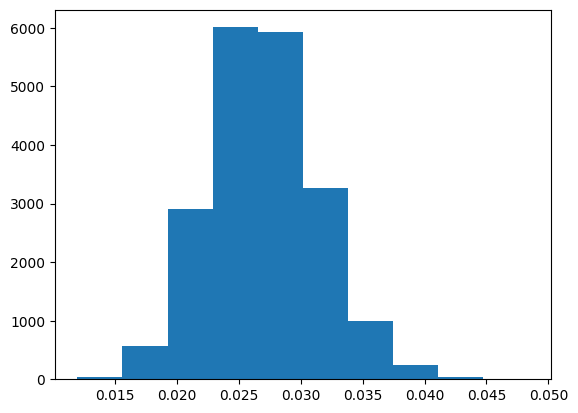

In [1352]:
plt.hist(neg_grad)

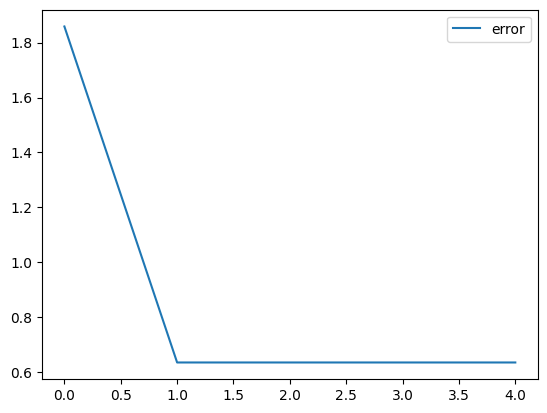

In [1354]:
plt.plot(errors, label='error')
# plt.plot(losses, label='loss')
# plt.yscale('log')
plt.legend()

In [1362]:
k = 10
mse = []
for _ in range(30):
    s = np.random.choice(np.arange(len(x_sell)), p=w / w.sum(), size=k, replace=False)
    mse.append(frank_wolfe.MSE(
        x_buy, y_buy, 
        frank_wolfe.least_norm_linear_regression(x_sell[s], y_sell[s])
    ))
print('Ours', np.mean(mse).round(2))

mse = []
for _ in range(30):
    s = np.random.choice(np.arange(len(x_sell)), size=k, replace=False)
    mse.append(frank_wolfe.MSE(
        x_buy, y_buy, 
        frank_wolfe.least_norm_linear_regression(x_sell[s], y_sell[s])
    ))
print('Random', np.mean(mse).round(2))

# s = [239, 65, 592, 185, 331, 174]

s = frank_wolfe.compute_neg_gradient(x_sell, x_buy, np.linalg.pinv(np.dot(x_sell.T, x_sell))).argsort()[::-1][:k]
print(s)

print('grad', frank_wolfe.MSE(
    x_buy, y_buy, 
    frank_wolfe.least_norm_linear_regression(x_sell[s], y_sell[s])
).round(2))

t = w.argsort()[::-1][:k]
print(t)
print('design', frank_wolfe.MSE(
    x_buy, y_buy, 
    frank_wolfe.least_norm_linear_regression(x_sell[t], y_sell[t])
).round(2))
print('overlap', f'{len(set(s) & set(t)) / len(s):.0%}')

Ours 1.47
Random 1.47
[11645 10656  7960 16284 13383 18205 11472  1704 18421  1472]
grad 1.32
[16284   800  9237 11472 11064 13383  3563 10520 11531 14104]
design 1.4
overlap 30%


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (20,) and arg 1 with shape (9900,).

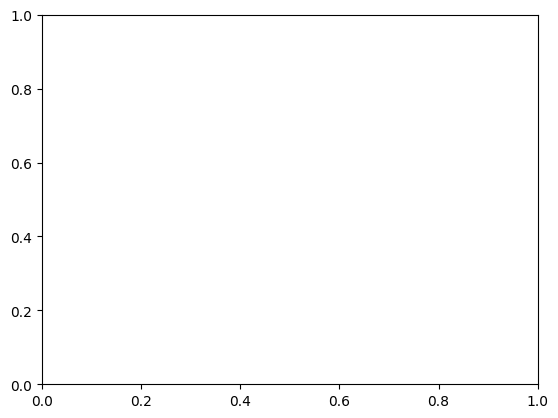

In [878]:
m = 20
plt.bar(np.arange(m), np.bincount(updates, minlength=m))
plt.xlabel('Datapoint', fontsize=14)
plt.ylabel('Weight', rotation=0, fontsize=14, labelpad=32)
plt.axvline(10, c='k')
# plt.axvline(20, c='k')
# plt.text(3, 11.5, r'$ h(c) = 1$', fontsize=14)
# plt.text(11, 11, r'$ h(c) = c^2$' '\n' r'$c \in linspace(0.5, 1.5)$', fontsize=14)

plt.text(0, 11, r'$ h(c) = c^2$' '\n' r'$c \in linspace(0.5, 1.5)$', fontsize=14)
plt.text(11, 11, r'$ h(c) = c^2$' '\n' r'$c \in linspace(1.5, 0.5)$', fontsize=14)

In [ ]:
dummy = np.ones((4, x_sell.shape[1])), np.ones((4))
oob_values = main_gaussian.get_baseline_values(x_sell, y_sell, *dummy, *dummy, 
                                               baseline_kwargs={"DataOob": {"num_models": 50}},)

# k = 20
# k = 10
# k = 5

# select = w.argsort()[-k:]
# select = np.random.choice(np.arange(len(x_sell)), p=w / w.sum(), size=k, replace=False)
# select = oob_values[0]['DataOob'].argsort()[-k:]

trials = 5
rang = list(range(2, 20, 2)) + list(range(20, 300, 10))
rand_err  = []
rand_cost = []
for _ in range(trials):
    perm = np.random.permutation(np.arange(x_sell.shape[0]))
    rand_err.append([
        frank_wolfe.MSE(
            x_buy, y_buy, 
            frank_wolfe.least_norm_linear_regression(x_sell[perm][:k], y_sell[perm][:k])
        )
        for k in rang
    ])
    rand_cost.append([costs[perm][:k].sum() for k in rang])
design_err = []
design_cost = []
for _ in range(trials):
    derr = []
    dcos = []
    for k in rang:
        sel = np.random.choice(np.arange(len(x_sell)), p=w / w.sum(), size=k, replace=False)
        dcos.append(costs[sel].sum())
        derr.append(frank_wolfe.MSE(
            x_buy, y_buy, 
            frank_wolfe.least_norm_linear_regression(x_sell[sel], y_sell[sel]),
        ))
    design_err.append(derr)
    design_cost.append(dcos)

    
plt.plot(
    np.mean(rand_cost, 0),
    np.mean(rand_err, 0),
    label='Random', ls='--', c='C2', marker='o'
)
plt.plot(
    np.mean(design_cost, 0),
    np.mean(design_err, 0),
    label='Design', ls='--', c='C0', marker='*',
)
                
# plt.plot(
#     [costs[w.argsort()[-k:]].sum() for k in rang], [
#     frank_wolfe.MSE(
#         x_buy, y_buy, 
#         frank_wolfe.least_norm_linear_regression(x_sell[(s := )], y_sell[s]))
#     for k in rang
# ], label='Design (sampled)', ls='--', c='C0')

# plt.plot(
#     [costs[w.argsort()[-k:]].sum() for k in rang], [
#     frank_wolfe.MSE(
#         x_buy, y_buy, 
#         frank_wolfe.least_norm_linear_regression(x_sell[w.argsort()[-k:]], y_sell[w.argsort()[-k:]]))
#     for k in rang
# ], label='Design', ls='-', c='C0', marker='*')
plt.plot(
    [costs[oob_values[0]['DataOob'].argsort()[-k:]].sum() for k in rang], [
    frank_wolfe.MSE(
        x_buy, y_buy, 
        frank_wolfe.least_norm_linear_regression(x_sell[(oob := oob_values[0]['DataOob'].argsort()[-k:])], y_sell[oob]))
    for k in rang
], label='Bagging', ls='--', c='C1', marker='^')


# plt.title(r'$h(c) = \sqrt{c}$', fontsize=16)
plt.title(r'$h(c) = c^2$', fontsize=16)
plt.xlabel('Cost', labelpad=10, fontsize=14)
plt.ylabel('Error', rotation=0, labelpad=30, fontsize=14)
plt.legend()
# plt.xlim(0, 30)
plt.ylim(0, 5)
# plt.bar(np.arange(30), np.bincount(updates, minlength=30))
plt.bar(np.arange(30), w[:30])

In [5]:
def design_selection(
    seller_data,
    buyer_data,
    num_select=100,
    num_iters=100,
    alpha=0.1,
    line_search=False,
    scale_cov=False,
    real_cov=False,
    topk=1,
    shrink=True,
    decay_alpha=False,
):
    x_sell, y_sell = seller_data
    x_buy, y_buy = buyer_data

    # initialize seller weights
    n_sell = x_sell.shape[0]
    # weights = np.ones(n_sell) * n_sell
    weights = np.ones(n_sell) / n_sell
    # weights = np.ones(n_sell) * num_iters
    # weights = np.ones(n_sell) 

    def scale(cov):
        cov -= cov.min()
        return cov / (cov.max() - cov.min())

    # inverse covariance matrix
    if real_cov:
        inv_cov = np.linalg.pinv(x_sell.T @ (np.diag(weights)) @ x_sell)
    else:
        inv_cov = np.eye(x_sell.shape[1]) 

    if scale_cov:
        inv_cov = scale(
            inv_cov
        )  # rescale inverse covariance matrix to be between 0 and 1

    # experimental design loss i.e. E[X_buy.T @ inv_cov @ X]
    loss = frank_wolfe.compute_exp_design_loss(x_buy, inv_cov)

    # track losses and errors
    coords = {}
    losses = {}
    errors = {}
    norms = {}
    conds = {}
    alphas = {}
    grads = {}

    for i in tqdm(range(num_iters)):

        if decay_alpha:
            alpha = 2 / (3 + i)
        
        # Pick coordinate with largest gradient to update
        neg_grad = frank_wolfe.compute_neg_gradient(x_sell, x_buy, inv_cov)
        grads[i] = neg_grad

        if topk > 1:
            sorted_grad = neg_grad.argsort()[::-1]
            update_coord = sorted_grad[:topk]
            coords[i] = update_coord
        else:
            update_coord = np.argmax(neg_grad)
            coords[i] = update_coord

        if line_search:
            alpha, loss = frank_wolfe.opt_step_size(
                x_sell[update_coord], x_buy, inv_cov, loss
            )

        if topk > 1:
            for i, g in enumerate(update_coord, start=1):
                weights[g] += alpha
            weights /= weights.sum()
        else:
            if shrink:
                weights *= 1 - alpha  
            weights[update_coord] += alpha  

        # inv_cov = np.linalg.pinv(x_sell.T @ np.diag(weights) @ x_sell)

        if shrink:
            inv_cov /= (1 - alpha)  
        
        if topk > 1:
            for i, coord in enumerate(update_coord, start=1):
                inv_cov = frank_wolfe.sherman_morrison_update_inverse( 
                    inv_cov,
                    alpha * x_sell[coord, :],
                    x_sell[coord, :],
                )
            
        else:
            inv_cov = frank_wolfe.sherman_morrison_update_inverse( 
                inv_cov,
                alpha * x_sell[update_coord, :],
                x_sell[update_coord, :],
            )

        if scale_cov:
            inv_cov = scale(
                inv_cov
            )

        selected_seller_indices = np.random.choice(np.arange(weights.shape[0]), size=num_select, p=weights / weights.sum(), replace=False)
        results = frank_wolfe.evaluate_indices(
            x_sell,
            y_sell,
            x_buy,
            y_buy,
            selected_seller_indices,
            inverse_covariance=inv_cov,
        )
        exp_loss = frank_wolfe.compute_exp_design_loss(x_buy, inv_cov)
        # losses[i] = results["exp_loss"]
        losses[i] = exp_loss
        errors[i] = results["mse_error"]
        norms[i] = np.linalg.norm(inv_cov, ord='fro')
        conds[i] = np.linalg.cond(x_sell.T @ np.diag(weights) @ x_sell)
        alphas[i] = alpha
        
    # weights /= weights.sum()
    return dict(losses=losses, errors=errors, 
                weights=weights, norms=norms, 
                conds=conds, coords=coords, alphas=alphas,
                sell=(x_sell, y_sell), buy=(x_buy, y_buy), 
                val=(x_val, y_val),
                grads=grads
               )

In [522]:
exp_trials = 3
num_buyer = 10
reload(main_gaussian)

gauss_buy_res = defaultdict(list)
gauss_sell_res = defaultdict(list)
gauss_val_res = defaultdict(list)
gauss_weight_res = defaultdict(list)
gauss_cond_res = defaultdict(list)
gauss_norm_res = defaultdict(list)
gauss_loss_res = defaultdict(list)
gauss_coord_res = defaultdict(list)
gauss_err_res = defaultdict(list)
# for k in [0, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
# for k in [0, 1, 2, 3]:
for k in [0.1, 1, 10]:
    for i in range(exp_trials):
        x_sell, y_sell, x_val, y_val, x_buy, y_buy, beta = main_gaussian.get_data(
            num_seller = 500,
            num_buyer = num_buyer,
            dim = 100,
            num_seller_subset=0,
            buyer_subset=False,
            noise_level=1,
            return_beta = True,
            random_seed=i,
            bone_data=False,
            # bone_data=True,
            # exponential=True,
            student_df=k,
        )
        # res = main_gaussian.design_selection(
        res = design_selection(
            (x_sell, y_sell), (x_buy, y_buy), 
            num_select=10, 
            # num_iters=100,
            num_iters=100,
            alpha=0.1,
            # scale_cov=True,
            scale_cov=False,
        )
        gauss_loss_res[k].append(res['losses'])
        # norm_res[k].append(res['norms'])
        # cond_res[k].append(res['conds'])
        gauss_err_res[k].append(res['errors'])
        # coord_res[k].append(res['coords'])
        gauss_weight_res[k].append(res['weights'])
        gauss_buy_res[k].append((x_buy, y_buy))
        gauss_sell_res[k].append((x_sell, y_sell))
        gauss_val_res[k].append((x_val, y_val))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
base_trials = 1
gauss_base_weights = defaultdict(list)
for k in gauss_val_res.keys():
    for j, t in enumerate(range(base_trials)):
        print(t)

        baseline_values, baseline_runtimes = main_gaussian.get_baseline_values(
            *gauss_sell_res[k][j],
            *gauss_val_res[k][j],
            *gauss_val_res[k][j],
            # *gauss_buy_res[k][j],
                random_state=t,
                baselines={
                    "DataOob": {"num_models": 100},
                    "KNNShapley": {},
                }
        )
        gauss_base_weights[k].append(baseline_values)

0
----------------DataOob-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.29it/s]


	TIME: 5
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 945.18it/s]


	TIME: 1
0
----------------DataOob-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.23it/s]


	TIME: 5
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 920.54it/s]


	TIME: 1
0
----------------DataOob-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.22it/s]


	TIME: 5
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 927.66it/s]

	TIME: 1


In [30]:
import matplotlib
cmap = matplotlib.colormaps['plasma'].colors
colors = np.array(cmap)[np.linspace(20, 255, 5).astype(int)]

lw=3
gauss_exp_errors = {}
gauss_base_errors = {}
gauss_knn_errors = {}
gauss_bag_errors = {}
rang = np.arange(2, 200, 5)
for k, v in gauss_weight_res.items():
    gauss_exp_errors[k] = np.mean([[evaluate_subset(
        np.random.choice(np.arange(v[t].shape[0]), size=j, p=v[t], replace=False),
        *gauss_sell_res[k][t], *gauss_buy_res[k][t]
    ) for j in rang] for t in range(exp_trials)], 0)
    print('exp done')
    gauss_base_errors[k] = np.mean([[evaluate_subset(
        np.arange(j), *gauss_sell_res[k][t], *gauss_buy_res[k][t]
    ) for j in rang] for t in range(exp_trials)], 0)
    print('base done')
    gauss_knn_errors[k] = np.mean([[evaluate_subset(
            gauss_base_weights[k][t]['KNNShapley'].argsort()[::-1][:j],
            *gauss_sell_res[k][t], *gauss_buy_res[k][t]
        ) for j in rang] for t in range(base_trials)], 0)
    print('knn done')
    gauss_bag_errors[k] = np.mean([[evaluate_subset(
        gauss_base_weights[k][t]['DataOob'].argsort()[::-1][:j],
        *gauss_sell_res[k][t], *gauss_buy_res[k][t]
    ) for j in rang] for t in range(base_trials)], 0)
    print('bag done')

exp done
base done
knn done
bag done
exp done
base done
knn done
bag done
exp done
base done
knn done
bag done


Text(0.5, 0, 'Number of points selected')

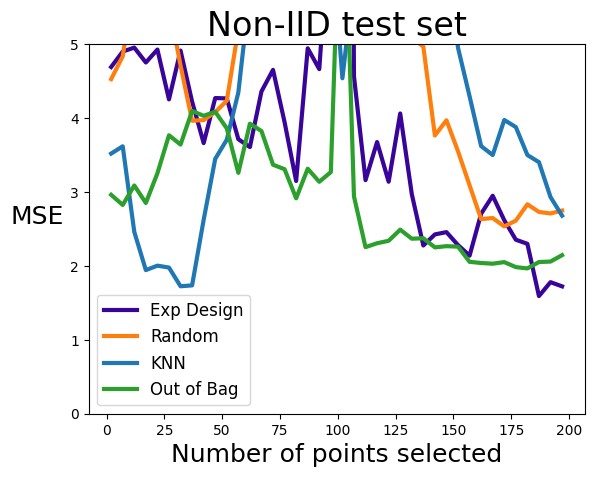

In [33]:
k = 0.1
k = 1
# k = 10
# lw = 3
# fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
# plt.title('IID test set', fontsize=24)
plt.title('Non-IID test set', fontsize=24)
plt.plot(rang, gauss_exp_errors[k], label=f'Exp Design', c=colors[0], lw=lw)
plt.plot(rang, gauss_base_errors[k], label=f'Random', c='C1', ls='-', lw=lw)
plt.plot(rang, gauss_knn_errors[k], label='KNN', c='C0', lw=lw,)
plt.plot(rang, gauss_bag_errors[k], label=f'Out of Bag', c='C2', lw=lw)
# plt.legend(fontsize=12, bbox_to_anchor=(1, 1))
plt.legend(fontsize=12)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=24)
# plt.ylim(0, 10)
plt.ylim(0, 5)
plt.xlabel('Number of points selected', fontsize=18)
# plt.savefig('gaussian-iid.eps', format='eps', bbox_inches='tight')
# plt.savefig('gaussian-non-iid.eps', format='eps', bbox_inches='tight')

In [43]:
exp_trials = 5
exp_trials = 1
num_buyer = 100
reload(main_gaussian)

bone_buy_res = defaultdict(list)
bone_sell_res = defaultdict(list)
bone_val_res = defaultdict(list)
bone_weight_res = defaultdict(list)
bone_cond_res = defaultdict(list)
bone_norm_res = defaultdict(list)
bone_loss_res = defaultdict(list)
bone_coord_res = defaultdict(list)
bone_err_res = defaultdict(list)
bone_grad_res = defaultdict(list)
# for k in [0, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
# for k in [0, 1, 2, 3]:
for k in [0]:
    for i in range(exp_trials):
        x_sell, y_sell, x_val, y_val, x_buy, y_buy, beta = main_gaussian.get_data(
            num_seller = 1000,
            num_buyer = num_buyer,
            dim = 100,
            num_seller_subset=1,
            buyer_subset=False,
            noise_level=1,
            return_beta = True,
            random_seed=i,
            bone_data=True,
            cluster=False,
            # n_clusters=50,
        )
        # x_buy += 0.001 * np.random.uniform(size=x_buy.shape)
        print(x_buy.shape)
        # res = main_gaussian.design_selection(
        b = 0
        res = design_selection(
            (x_sell[b:], y_sell[b:]), (x_buy, y_buy), 
            # (x_sell[:], y_sell[:]), (x_buy, y_buy), 
            num_select=10, 
            # num_iters=100,
            num_iters=num_buyer,
            alpha=0.1,
            # scale_cov=True,
            real_cov=True,
            # topk=40,
            shrink=True,
            # decay_alpha=True,
        )
        bone_loss_res[k].append(res['losses'])
        bone_err_res[k].append(res['errors'])
        bone_weight_res[k].append(res['weights'])
        bone_buy_res[k].append((x_buy, y_buy))
        bone_sell_res[k].append((x_sell, y_sell))
        bone_val_res[k].append((x_val, y_val))
        
        bone_norm_res[k].append(res['norms'])
        bone_cond_res[k].append(res['conds'])
        bone_coord_res[k].append(res['coords'])
        bone_grad_res[k].append(res['grads'])

(100, 1000)


  0%|          | 0/100 [00:00<?, ?it/s]

In [44]:
base_trials = 1

bone_base_weights = defaultdict(list)
for k in bone_val_res.keys():
    for j, t in enumerate(range(base_trials)):
        print(t)

        baseline_values, baseline_runtimes = main_gaussian.get_baseline_values(
            *bone_sell_res[k][j],
            *bone_val_res[k][j],
            *bone_val_res[k][j],
            # *bone_buy_res[k][j],
                random_state=t,
                baselines=["DataOob", "KNNShapley", "LavaEvaluator"],
                baseline_kwargs={
                    "DataOob": {"num_models": 10},
                    "KNNShapley": {},
                }
        )
        bone_base_weights[k].append(baseline_values)

0
----------------DataOob-----------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.52s/it]


	TIME: 55
---------------KNNShapley---------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1099/1099 [00:01<00:00, 783.34it/s]


	TIME: 2
-------------LavaEvaluator--------------


	TIME: 0


In [52]:
bone_grad_res[0][0][0].argsort()[-100:]

array([46, 18,  3, 93, 17, 48, 23, 44, 28, 32, 24, 50,  9, 70, 76, 49,  0,
       90, 26, 51, 14, 59, 66, 75, 54, 61, 95, 67, 43, 92, 25, 99, 19, 68,
       33, 11, 16, 21, 10, 20, 94, 60, 22, 56, 36, 57, 71, 55,  2, 30, 39,
       91, 79, 35, 45, 34, 86, 47, 29, 82, 84,  8, 78, 98, 69, 53, 74, 63,
       37, 87, 88, 40, 27, 65,  4, 41, 80, 72, 85, 52, 62, 96, 81,  6,  1,
       89,  5, 83, 73, 15, 97, 12, 38, 58, 42, 64,  7, 13, 77, 31])

In [58]:
np.unique(list(bone_coord_res[0][0].values())).shape

(100,)

In [59]:
bone_weight_res[0][0].argsort()

array([708, 716, 715, ...,  48,  18,  46])

In [48]:
import matplotlib
cmap = matplotlib.colormaps['plasma'].colors
colors = np.array(cmap)[np.linspace(20, 255, 5).astype(int)]

lw=3
# use_ridge = True
use_ridge = False
bone_exp_errors = {}
bone_base_errors = {}
bone_knn_errors = {}
bone_bag_errors = {}
bone_lava_errors = {}

rang = np.arange(2, 100, 10)
for k, v in bone_weight_res.items():
    bone_exp_errors[k] = np.mean([[evaluate_subset(
        np.random.choice(np.arange(v[t].shape[0]), size=j, p=v[t] / v[t].sum(), replace=False),
        *bone_sell_res[k][t], *bone_buy_res[k][t],
        use_ridge=use_ridge,
    ) for j in rang] for t in range(exp_trials)], 0)
    print('exp done')
    bone_base_errors[k] = np.mean([[evaluate_subset(
        np.random.choice(np.arange(v[t].shape[0]), size=j, replace=False),
 *bone_sell_res[k][t], *bone_buy_res[k][t],
        use_ridge=use_ridge,
    ) for j in rang] for t in range(exp_trials)], 0)
    print('base done')
    bone_knn_errors[k] = np.mean([[evaluate_subset(
            bone_base_weights[k][t]['KNNShapley'].argsort()[::-1][:j],
            *bone_sell_res[k][t], *bone_buy_res[k][t],
        use_ridge=use_ridge,
        ) for j in rang] for t in range(base_trials)], 0)
    print('knn done')
    bone_bag_errors[k] = np.mean([[evaluate_subset(
        bone_base_weights[k][t]['DataOob'].argsort()[::-1][:j],
        *bone_sell_res[k][t], *bone_buy_res[k][t],
        use_ridge=use_ridge,
    ) for j in rang] for t in range(base_trials)], 0)
    print('bag done')
    bone_lava_errors[k] = np.mean([[evaluate_subset(
        bone_base_weights[k][t]['LavaEvaluator'].argsort()[::-1][:j],
        *bone_sell_res[k][t], *bone_buy_res[k][t],
        use_ridge=use_ridge,
    ) for j in rang] for t in range(base_trials)], 0)
    print('lava done')

exp done
base done
knn done
bag done
lava done


Text(0.5, 0, 'Number of points selected')

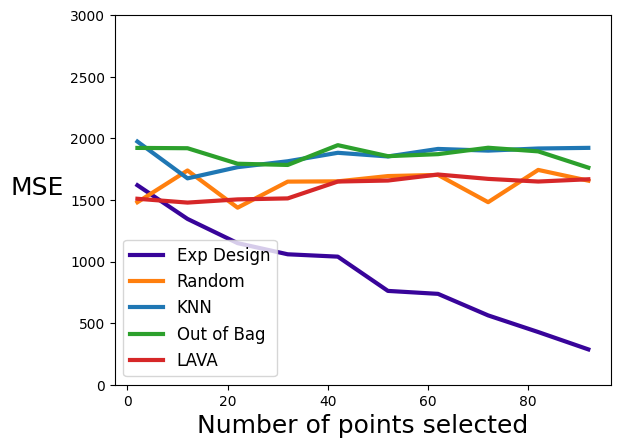

In [49]:
k = 0
# lw = 3
# fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
# plt.title('IID test set', fontsize=24)
# plt.title('Non-IID test set', fontsize=24)
# plt.title('Bone age', fontsize=24)
plt.plot(rang, bone_exp_errors[k], label=f'Exp Design', c=colors[0], lw=lw)
plt.plot(rang, bone_base_errors[k], label=f'Random', c='C1', ls='-', lw=lw)
plt.plot(rang, bone_knn_errors[k], label='KNN', c='C0', lw=lw,)
plt.plot(rang, bone_bag_errors[k], label=f'Out of Bag', c='C2', lw=lw)
plt.plot(rang, bone_lava_errors[k], label=f'LAVA', c='C3', lw=lw)
# plt.legend(fontsize=12, bbox_to_anchor=(1, 1))
plt.legend(fontsize=12)
plt.ylabel('MSE', fontsize=18, rotation=0, labelpad=24)
plt.ylim(0, 3000)
# plt.ylim(0, 5)
plt.xlabel('Number of points selected', fontsize=18)
# plt.savefig('bone-iid.eps', format='eps', bbox_inches='tight')
# plt.savefig('bone-non-iid.eps', format='eps', bbox_inches='tight')

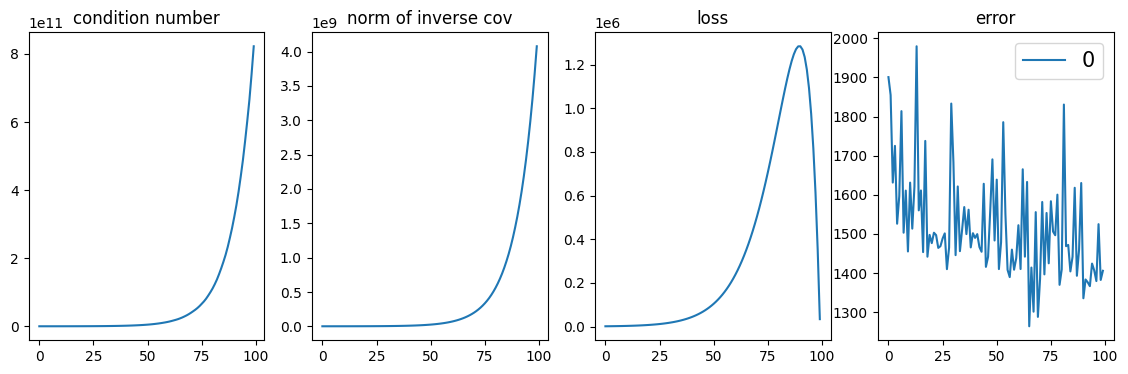

In [50]:
fig, ax = plt.subplots(ncols=4, figsize=(14, 4))
for x in bone_loss_res.keys():
# for x in alphas[:-1]:
# for x in iters:
    ax[0].plot(bone_cond_res[x][0].keys(), np.mean([list(x_i.values()) for x_i in bone_cond_res[x]], 0), label=x,)
    ax[1].plot(bone_norm_res[x][0].keys(), np.mean([list(x_i.values()) for x_i in bone_norm_res[x]], 0), label=x,)
    ax[2].plot(bone_loss_res[x][0].keys(), np.mean([list(x_i.values()) for x_i in bone_loss_res[x]], 0), label=x,)
    ax[3].plot(bone_err_res[x][0].keys(), np.mean([list(x_i.values()) for x_i in bone_err_res[x]], 0), label=x,)
ax[0].set_title('condition number')
ax[1].set_title('norm of inverse cov')
ax[2].set_title('loss')
ax[3].set_title('error')

plt.legend(fontsize=15)

In [293]:
loss

292.41529772850873

In [494]:
# initialize seller weights
alpha = 0.1
X = x_sell[5:]
# X -= X.mean(0) 
n_sell = X.shape[0]
weights = np.ones(n_sell) / n_sell
# weights = np.ones(n_sell) 
# weights /= (1 - alpha)
# weights[0] += alpha
inv_cov = np.linalg.pinv(X.T @ (np.diag(weights)) @ X)
# inv_cov = np.eye(x_sell.shape[1])

loss = frank_wolfe.compute_exp_design_loss(x_buy, inv_cov)
neg_grad = frank_wolfe.compute_neg_gradient(X, x_buy, inv_cov)
update_coord = np.argmax(neg_grad)
print(update_coord)
# np.mean((x_buy @ inv_cov @ X.T)**2, 0).argsort()
# weights.argsort()
neg_grad.argsort()

17


array([399, 441, 250, 306, 483, 327, 186, 302, 440, 378, 239,  35,  36,
       402,  30, 211, 312, 387, 393, 143, 271,  88, 289, 166,  27,  89,
       403, 396, 290, 510, 242, 305, 222, 284, 199, 361, 516, 101, 206,
       435, 233, 409, 337, 103, 434, 129, 297, 473, 374, 328, 148, 268,
       478, 465, 165, 464, 221, 121, 523,  80, 390, 303, 364, 235, 341,
       323,  98, 204,  38, 477, 505, 114, 236, 273, 270,  74, 426,  56,
        40,  49, 455, 283,  55, 294, 247,  29, 141, 485, 137, 346, 517,
       123, 419, 249, 469, 326, 411, 385, 386, 266, 458, 314, 109,  26,
       394, 369, 331, 515,  34,  84, 362, 190,  94, 279, 336, 333, 377,
        91, 484, 521, 161, 169, 298,  71, 481, 267, 311, 382, 223, 329,
       177, 352, 292, 149, 274, 253, 189, 112,  39, 415, 152,  37, 338,
       353,  63,  68,  77, 425,  58, 195, 116, 225, 216, 200,  93, 325,
       400,  95, 431, 100, 300, 445,  96, 424, 258, 324, 170, 389, 138,
       423, 388, 231, 133,  45, 117, 351,  92,  25, 391, 224, 25

In [497]:
neg_grad.argsort()[-26:]

array([54, 24,  5, 10, 21,  2, 14,  8, 22, 13,  9,  4, 23,  1, 19,  6,  0,
        3, 16, 11,  7, 18, 12, 15, 20, 17])

In [461]:
k = [38, 81]
# k = [51, 72]
# k = [36, 81]
x_k = x_sell[k]
y_k = y_sell[k]
proj_sell = (x_k.T @ np.linalg.pinv(x_k @ x_k.T) @ x_k)
proj_buy = (x_buy.T @ np.linalg.pinv(x_buy @ x_buy.T) @ x_buy)
print(np.mean(np.linalg.norm(x_buy @ proj_sell, axis=1)))
print(np.mean(np.linalg.norm(x_k @ proj_buy, axis=1)))

0.11652863887371805
0.279346642389638


In [462]:
np.linalg.norm(frank_wolfe.least_norm_linear_regression(x_k, y_k) - beta)

13.828745009964125

In [463]:
X = np.concatenate([x_buy[:], x_sell])
P = np.linalg.pinv(X.T @ X)
np.linalg.norm(x_buy @ P @ X.T, axis=0).argsort()
np.linalg.norm(x_buy @ X.T, axis=0).argsort()

array([535, 299, 710, ...,   8,   5,   7])

In [1100]:
np.linalg.norm(x_buy @ x_sell.T, axis=0).argsort()

array([69, 30, 95, 59, 25, 36, 80, 81,  8, 11, 70, 66, 86, 92, 18, 47, 83,
        0, 84,  7, 38, 75, 14, 23, 97, 58, 10, 99, 21, 65, 34, 48, 78, 89,
       87, 94, 82, 12, 57,  1, 93, 55, 56,  9, 40, 28, 13, 63, 90,  5, 91,
       35, 61, 67, 27, 24, 39, 76, 71, 96, 52, 16, 19,  4, 37, 17, 46, 42,
       20, 43, 54, 77, 88, 73, 62, 33,  2,  3, 50, 22, 98, 41, 60, 85, 53,
       44, 64, 32, 79,  6, 26, 29, 68, 49, 45, 15, 74, 31, 51, 72])

In [1088]:
w = np.diag(np.ones(x_sell.shape[0]) ) 
w[0, 0] = 0.9
w[1, 1] = 0.9
# w[2, 2] = 0.9
# w / w.sum()
P = np.linalg.inv(x_sell.T @ w @ x_sell)
frank_wolfe.compute_exp_design_loss(x_buy, P)

0.12939651497204313